In [1]:
!pip install split-folders

In [2]:
import os
import torchvision
import torch
import time
import splitfolders
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
data_dir = '../input/all-brain-datset/all_dataset'
batch_size=32
image_size=224

In [4]:
splitfolders.ratio(data_dir+ "/Training", output='brain-tumor-classification-mri', ratio=(0.8,0.1,0.1))

Copying files: 3264 files [00:19, 164.65 files/s]


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
image_size = (224,224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])


dataset_training = ImageFolder( "./brain-tumor-classification-mri/train", transform=transform)
dataset_validating = ImageFolder( "./brain-tumor-classification-mri/val", transform=transform)
dataset_testing = ImageFolder( "./brain-tumor-classification-mri/test", transform=transform)

print(f'Size train {len(dataset_training)}') 
print(f'Size valid {len(dataset_validating)}')
print(f'Size train {len(dataset_testing)}')

Size train 2609
Size valid 325
Size train 330


In [7]:
batch_size=32
train_loader = DataLoader(dataset_training,batch_size=batch_size,shuffle=True)
val_loader =  DataLoader(dataset_validating,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(dataset_testing,batch_size=batch_size,shuffle=False)

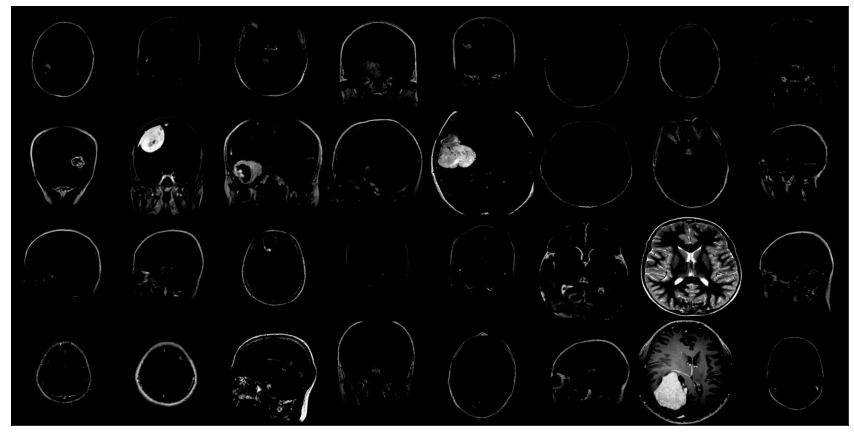

In [8]:
examples = iter(train_loader)
img,labels = examples.next()
def show_batch(dataset_loader):
    _, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img).permute(1, 2, 0))
show_batch(train_loader)

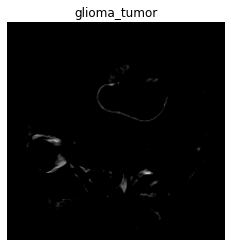

In [9]:
def show_image(img, label):
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'{dataset_training.classes[label]}')
    plt.axis("off")
    plt.show()

show_image(*dataset_training[11])

In [10]:
def training_step(model, batch):
    images, labels = batch
    if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
    out = model(images)  
    loss = F.cross_entropy(out, labels)  
    acc = accuracy(out, labels) 
    return {'train_loss': loss,'train_acc':acc}

def validation_step(model, batch):
    images, labels = batch
    if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
    out = model(images)  
    loss = F.cross_entropy(out, labels)  
    acc = accuracy(out, labels)  
    return {'val_loss': loss.detach(), 'val_acc': acc}

def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() 
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()  
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(epoch, result):
    print("Epoch [{}], time(s): {:.4f}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['epoch_time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

def test_step(model, batch):
    images, labels = batch
    if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
    out = model(images)  
    acc = accuracy(out, labels) 
    return {'y_test': labels, 'prediction': out}

def test_end(outputs, name):
    y_test = [y.item() for x in outputs for y in x['y_test'] ]
    y_prediction = [torch.argmax(y).item() for x in outputs for y in x['prediction']]
    
    report = classification_report(y_test, y_prediction, target_names=dataset_training.classes)
    print(f'Test {name} Pytorch')
    print(f'{report}')
    
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ax.set_title(f'Confusion Matrix {name} Pytorch')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dataset_training.classes)
    disp.plot(cmap='Blues', ax=ax)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

@torch.no_grad()
def test(model, test_loader, name):
    model.eval()
    outputs = [test_step(model, batch) for batch in test_loader]
    return test_end(outputs, name)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        t0 = time.time()
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = training_step(model, batch)
            train_losses.append(outputs['train_loss'])
            train_accuracy.append(outputs['train_acc'])
            outputs['train_loss'].backward()
            optimizer.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        result['epoch_time'] = time.time() - t0
        epoch_end(epoch, result)
        history.append(result)
    return history

In [12]:
def display_plot(history, name):
    acc = [epoch["train_acc"] for epoch in history]
    val_acc = [epoch["val_acc"] for epoch in history]

    loss = [epoch['train_loss'] for epoch in history]
    val_loss = [epoch['val_loss'] for epoch in history]

    plt.figure(figsize=(14, 8))
    tab_plot = [{
                "id": 1,
                "variables":[acc, val_acc],
                "labels":['Training Accuracy', 'Validation Accuracy'],
                "legend":'lower right',
                "title":f'Accuracy Pytorch - {name}',
                "ylabel":'Accuracy'
            },{ 
                "id": 2,
                "variables":[loss, val_loss],
                "labels":['Training Loss', 'Validation Loss'],
                "legend":'upper right',
                "title":f'Loss Pytorch - {name}',
                "ylabel":'Loss'
            }]
    

    epochs_range = range(25)
    for tab in tab_plot: 
        plt.subplot(1, 2, tab['id'])
        plt.plot(epochs_range,  tab['variables'][0], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
        plt.plot(epochs_range , tab['variables'][1], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
        plt.legend(loc=tab['legend'])
        plt.title(tab['title'])
        plt.xlabel('Epochs')
        plt.ylabel(tab['ylabel'])
    plt.show()

In [13]:
model_mobilenet_v2 = models.mobilenet_v2(pretrained=True)
model_mobilenet_v2.classifier[1] = nn.Linear(1280, 4)
model_mobilenet_v2.to(device)
model_mobilenet_v2.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [14]:
opt_func = torch.optim.Adam
lr = 0.001
print('Train Mobilenetv2 Pytorch')
history_mobilenet_v2= fit(25, lr, model_mobilenet_v2, train_loader, val_loader, opt_func)

Train Mobilenetv2 Pytorch
Epoch [0], time(s): 28.4814, train_loss: 0.5001, train_acc: 0.8240, val_loss: 0.3321, val_acc: 0.8892
Epoch [1], time(s): 22.3511, train_loss: 0.2386, train_acc: 0.9186, val_loss: 0.4432, val_acc: 0.8295
Epoch [2], time(s): 23.0105, train_loss: 0.1825, train_acc: 0.9379, val_loss: 0.2452, val_acc: 0.9205
Epoch [3], time(s): 22.9068, train_loss: 0.1446, train_acc: 0.9497, val_loss: 0.2059, val_acc: 0.9375
Epoch [4], time(s): 22.4262, train_loss: 0.1093, train_acc: 0.9631, val_loss: 0.1987, val_acc: 0.9432
Epoch [5], time(s): 22.7525, train_loss: 0.0872, train_acc: 0.9722, val_loss: 0.1839, val_acc: 0.9460
Epoch [6], time(s): 22.7345, train_loss: 0.0822, train_acc: 0.9734, val_loss: 0.1922, val_acc: 0.9318
Epoch [7], time(s): 22.1875, train_loss: 0.1182, train_acc: 0.9658, val_loss: 0.2029, val_acc: 0.9176
Epoch [8], time(s): 22.7641, train_loss: 0.1141, train_acc: 0.9624, val_loss: 0.1627, val_acc: 0.9318
Epoch [9], time(s): 22.6537, train_loss: 0.0935, train_a

Test Mobilenetv2 Pytorch
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.95      0.96        94
meningioma_tumor       0.96      0.97      0.96        95
        no_tumor       0.94      0.98      0.96        50
 pituitary_tumor       0.99      0.98      0.98        91

        accuracy                           0.97       330
       macro avg       0.96      0.97      0.97       330
    weighted avg       0.97      0.97      0.97       330



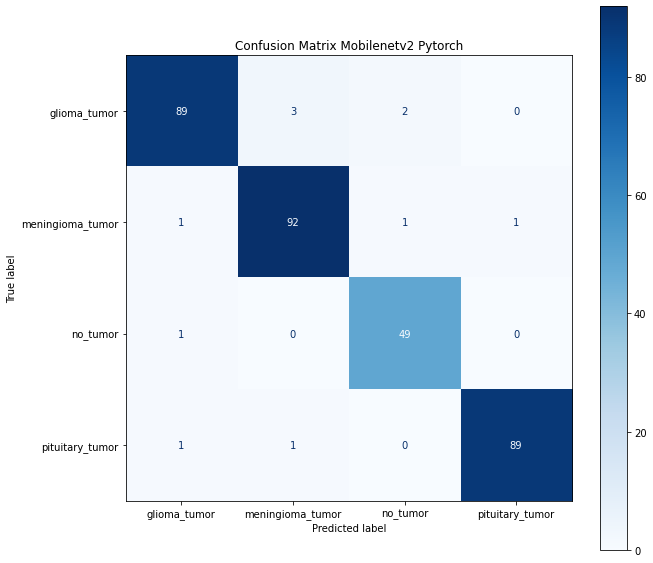

In [15]:
test(model_mobilenet_v2,test_loader, 'Mobilenetv2')

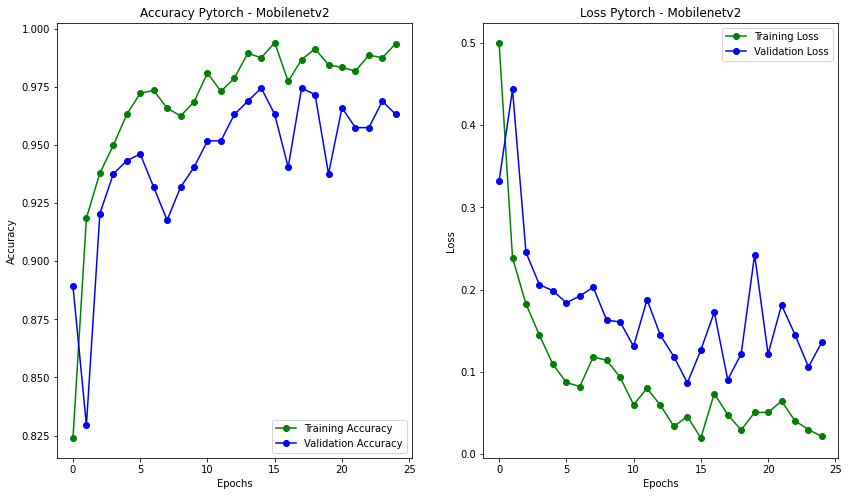

In [16]:
display_plot(history_mobilenet_v2, 'Mobilenetv2')

In [17]:
model_densenet121 = models.densenet121(pretrained=True)
model_densenet121.classifier = nn.Linear(1024, 4)
model_densenet121.to(device)
model_densenet121.eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [18]:
print('Train DenseNet121 Pytorch')
history_densenet121 = fit(25, lr, model_densenet121, train_loader, val_loader, opt_func)

Train DenseNet121 Pytorch
Epoch [0], time(s): 32.5066, train_loss: 0.4749, train_acc: 0.8350, val_loss: 0.2521, val_acc: 0.9148
Epoch [1], time(s): 32.5835, train_loss: 0.2660, train_acc: 0.9109, val_loss: 0.5459, val_acc: 0.7869
Epoch [2], time(s): 32.5884, train_loss: 0.1950, train_acc: 0.9303, val_loss: 0.4837, val_acc: 0.8636
Epoch [3], time(s): 32.4426, train_loss: 0.1758, train_acc: 0.9437, val_loss: 0.7265, val_acc: 0.7841
Epoch [4], time(s): 32.6404, train_loss: 0.1350, train_acc: 0.9536, val_loss: 0.5287, val_acc: 0.8199
Epoch [5], time(s): 32.3742, train_loss: 0.1248, train_acc: 0.9585, val_loss: 0.2993, val_acc: 0.9119
Epoch [6], time(s): 32.4559, train_loss: 0.1206, train_acc: 0.9601, val_loss: 0.2169, val_acc: 0.9432
Epoch [7], time(s): 32.6680, train_loss: 0.1024, train_acc: 0.9654, val_loss: 0.3421, val_acc: 0.9006
Epoch [8], time(s): 32.6597, train_loss: 0.1374, train_acc: 0.9604, val_loss: 0.1901, val_acc: 0.9460
Epoch [9], time(s): 32.4812, train_loss: 0.0697, train_a

Test DenseNet121 Pytorch
                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.86      0.91        94
meningioma_tumor       0.99      0.89      0.94        95
        no_tumor       0.89      1.00      0.94        50
 pituitary_tumor       0.88      1.00      0.94        91

        accuracy                           0.93       330
       macro avg       0.93      0.94      0.93       330
    weighted avg       0.93      0.93      0.93       330



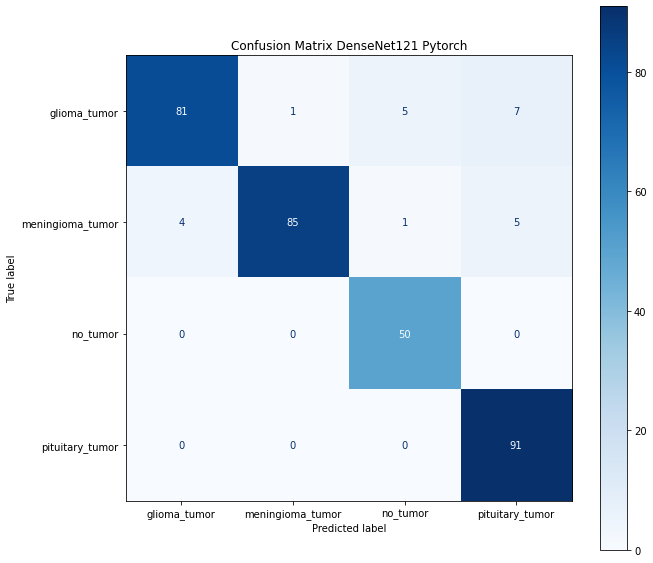

In [19]:
test(model_densenet121,test_loader, 'DenseNet121')

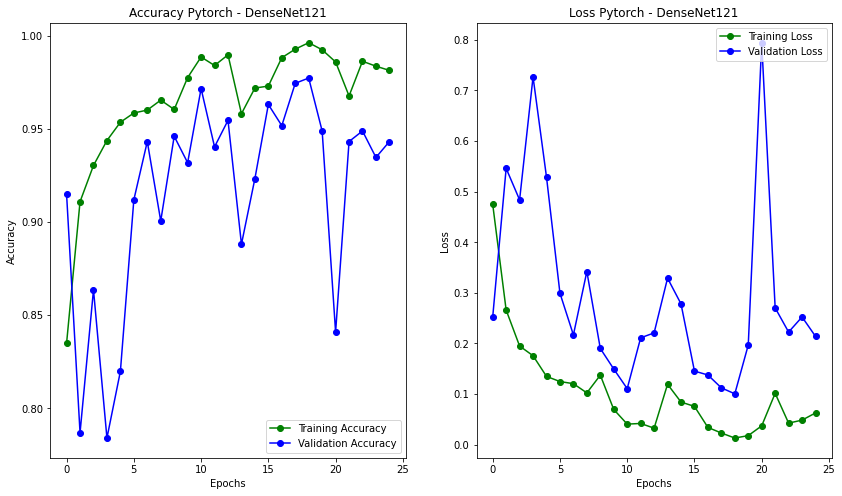

In [20]:
display_plot(history_densenet121, 'DenseNet121')

In [21]:
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc = nn.Linear(2048, 4)
model_resnet50.to(device)
model_resnet50.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
print('Train Resnet50 Pytorch')
history_resnet50 = fit(25, lr, model_resnet50, train_loader, val_loader, opt_func)

Train Resnet50 Pytorch
Epoch [0], time(s): 29.8871, train_loss: 0.6745, train_acc: 0.7495, val_loss: 0.8347, val_acc: 0.6352
Epoch [1], time(s): 29.6249, train_loss: 0.3846, train_acc: 0.8682, val_loss: 0.5227, val_acc: 0.8494
Epoch [2], time(s): 29.7299, train_loss: 0.3243, train_acc: 0.8851, val_loss: 2.0234, val_acc: 0.6534
Epoch [3], time(s): 29.7252, train_loss: 0.2835, train_acc: 0.9074, val_loss: 0.8103, val_acc: 0.7006
Epoch [4], time(s): 29.4984, train_loss: 0.2123, train_acc: 0.9219, val_loss: 1.6579, val_acc: 0.5881
Epoch [5], time(s): 29.7318, train_loss: 0.1542, train_acc: 0.9471, val_loss: 2.6397, val_acc: 0.6392
Epoch [6], time(s): 29.3906, train_loss: 0.1566, train_acc: 0.9494, val_loss: 2.2298, val_acc: 0.6676
Epoch [7], time(s): 29.4335, train_loss: 0.1800, train_acc: 0.9414, val_loss: 0.5260, val_acc: 0.8170
Epoch [8], time(s): 29.5859, train_loss: 0.0990, train_acc: 0.9711, val_loss: 0.3031, val_acc: 0.8966
Epoch [9], time(s): 29.5908, train_loss: 0.1143, train_acc:

Test Resnet50 Pytorch
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.97      0.97        94
meningioma_tumor       1.00      0.94      0.97        95
        no_tumor       0.93      1.00      0.96        50
 pituitary_tumor       0.97      0.99      0.98        91

        accuracy                           0.97       330
       macro avg       0.97      0.97      0.97       330
    weighted avg       0.97      0.97      0.97       330



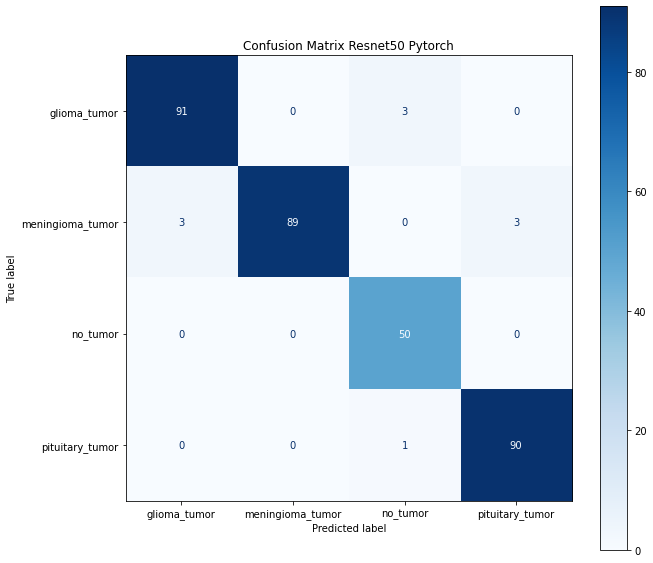

In [23]:
test(model_resnet50,test_loader, 'Resnet50')

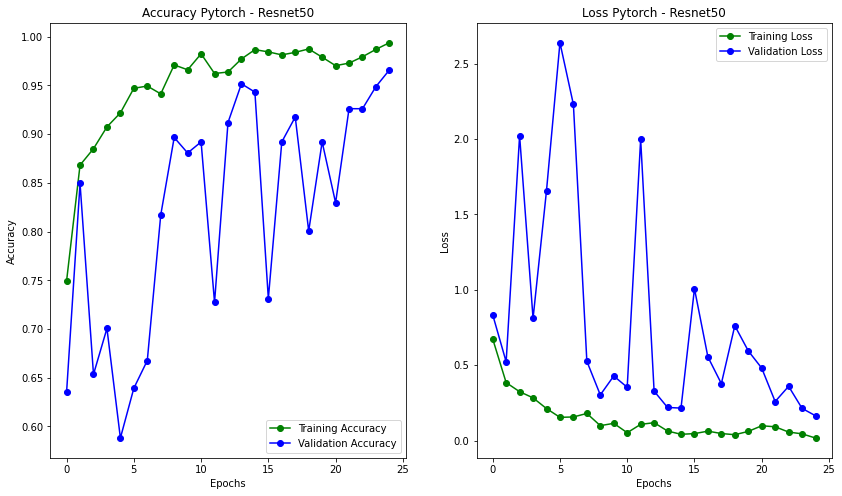

In [24]:
display_plot(history_resnet50, 'Resnet50')